In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pybats.shared import load_us_inflation_forecasts
from pybats.define_models import define_dglm
from pybats.analysis import analysis
from pybats.latent_factor import dlm_coef_lf
from pybats.point_forecast import mean
from pybats.loss_functions import MAPE
from pybats.plot import plot_corr, plot_data_forecast

In [4]:
data = load_us_inflation_forecasts()
dates = data['Dates']
dates

DatetimeIndex(['1977-09-30', '1977-12-31', '1978-03-31', '1978-06-30',
               '1978-09-30', '1978-12-31', '1979-03-31', '1979-06-30',
               '1979-09-30', '1979-12-31',
               ...
               '2012-09-30', '2012-12-31', '2013-03-31', '2013-06-30',
               '2013-09-30', '2013-12-31', '2014-03-31', '2014-06-30',
               '2014-09-30', '2014-12-31'],
              dtype='datetime64[ns]', length=150, freq='3M')

In [5]:
data.keys()

dict_keys(['Inflation', 'model_mean', 'model_var', 'Dates'])

{'Inflation': array([ 6.1510367,  6.5696465,  6.4454434,  6.8903143,  7.359638 ,
         7.2873668,  7.6029596,  8.2201887,  8.7128215,  8.5972144,
         8.907911 ,  8.6717962,  8.8484543,  9.6694336, 10.1200279,
         9.7783675,  9.2360898,  8.2901388,  7.1285176,  6.423529 ,
         6.0501698,  5.256121 ,  4.6398809,  4.0923956,  3.692503 ,
         3.3057617,  3.5722322,  3.7413125,  3.4966188,  3.4316403,
         3.5175508,  3.2904484,  3.0537461,  2.9583743,  2.2839388,
         2.0613915,  1.8805878,  1.8606132,  2.1026912,  2.3779568,
         2.7075668,  2.9848542,  3.0452104,  3.3467171,  3.8116624,
         3.7824996,  4.1063199,  4.1750185,  3.7099616,  3.6001218,
         3.6037598,  3.6045968,  3.7750804,  3.83837  ,  3.7305917,
         3.3713007,  3.2087518,  2.9898731,  2.4091155,  2.363538 ,
         2.0993202,  2.2381741,  2.3789338,  2.3480381,  2.4786375,
         2.3180652,  2.235237 ,  2.1225459,  2.0612383,  2.0921635,
         2.1809953,  2.1219034,  2.

In [7]:
data['model_mean']

,1,2,3,4
Dates,,,,
1977-Q3,6.233524,6.514003,6.468528,5.920357
1977-Q4,6.164432,6.184510,6.086730,6.061895
1978-Q1,6.581597,6.839483,6.750446,6.616881
1978-Q2,6.456939,6.664239,6.356655,6.592299
1978-Q3,6.901879,7.240702,7.050468,7.015126
...,...,...,...,...
2013-Q4,1.429337,1.466915,1.404796,1.428251
2014-Q1,1.407708,1.449510,1.414087,1.416752
2014-Q2,1.379603,1.451455,1.386820,1.401898


In [8]:
col = list(data.keys())
col

['Inflation', 'model_mean', 'model_var', 'Dates']

In [9]:
# for c in col:
ll_i = list(data['Inflation'])
ll_mm = list(data['model_mean'])
ll_mv = list(data['model_var'])
ll_date = list(data['Dates'])

In [10]:
len(ll_mm)

4

In [11]:
dat={'dates':ll_date,'Inflation':ll_i}
dat=pd.DataFrame(dat)
dat

,dates,Inflation
0,1977-09-30,6.151037
1,1977-12-31,6.569647
2,1978-03-31,6.445443
3,1978-06-30,6.890314
4,1978-09-30,7.359638
...,...,...
145,2013-12-31,1.396424
146,2014-03-31,1.368533
147,2014-06-30,1.636442
148,2014-09-30,1.571666


In [34]:
def load_us_inflation_forecasts():
    """
    Read in quarterly US inflation data along with forecasts from 4 models
    """
    data_dir = os.path.dirname(os.path.abspath(__file__)) + '/pkg_data/'

    # data = pd.read_csv(data_dir + 'bps_inflation.csv')
    data = pd.read_csv('out_clean.csv')
    dates = data.values[:,0]
    agent_mean = pd.read_csv(data_dir + 'bps_agent_mean.csv')
    agent_mean.columns = ['Dates', '1', '2', '3', '4']
    agent_mean.set_index('Dates', inplace=True)

    agent_var = pd.read_csv(data_dir + 'bps_agent_var.csv').values
    agent_dof = pd.read_csv(data_dir + 'bps_agent_dof.csv').values
    agent_var[:,1:] = agent_var[:,1:] * agent_dof[:,1:] / (agent_dof[:,1:]-2) # Adjust the agent variance for d.o.f. b/c they're t-distributed
    agent_var = pd.DataFrame(agent_var)
    agent_var.columns = ['Dates', '1', '2', '3', '4']
    agent_var.set_index('Dates', inplace=True)

    dates = pd.date_range('1977-09-01', '2014-12-31', freq='3M')
    Y = data['Inflation'].values

    data = {'Inflation':Y, 'model_mean':agent_mean, 'model_var':agent_var, 'Dates':dates}

    return data

In [35]:
from pybats.latent_factor import latent_factor

In [36]:
k = 1 #Forecast horizon: 1-quarter ahead
forecast_start = 50
forecast_end = 149
agents=[1,2,3,4]
nagents = len(agents)
Y = data['Inflation']

lf = latent_factor(
    mean = {d:m.astype('float64') for d, m in zip(dates, list(data['model_mean'].values))},
    var={d:np.diag(v).astype('float64') for d, v in zip(dates, list(data['model_var'].values))},
    forecast_mean={d:[m.astype('float64')] for d, m in zip(dates, list(data['model_mean'].values))},
    forecast_var={d:[np.diag(v).astype('float64')] for d,v in zip(dates, list(data['model_var'].values))},
    forecast_dates=dates,
    p = nagents,
    k = k)

KeyError: 'Inflation'

In [15]:
latent_factor.save(lf,filename='lf.txt')

In [16]:
lf

In [17]:
kwargs = {'a0':np.concatenate([np.zeros(1), np.array([1/nagents]*nagents)]).reshape(-1,1),
          'R0':np.identity(nagents+1) / 0.99,
          's0':0.01,
          'n0':5*0.99,
          'deltrend': 0.99,
          'dellf':0.99,
          'delVar':0.99
          }

mod_prior = define_dglm(Y=Y, X=None,
                        family='normal',
                        seasPeriods=[], seasHarmComponents=[[]],
                        nlf=4,
                        **kwargs)

In [18]:
prior_length = 0

samples, mod = analysis(Y, X = None, family = "normal",
                        prior_length = prior_length, k = 1, ntrend = 1, nsamps = 5000,
                        forecast_start = forecast_start, forecast_end = forecast_end,
                        model_prior = mod_prior,
                        latent_factor = lf,
                        dates = dates,
                        ret = ['forecast', 'model'],
                        **kwargs)

beginning forecasting


In [19]:
forecast = mean(samples)
np.round(MAPE(Y[forecast_start: forecast_end+1], forecast), 3)

12.648

<AxesSubplot: >

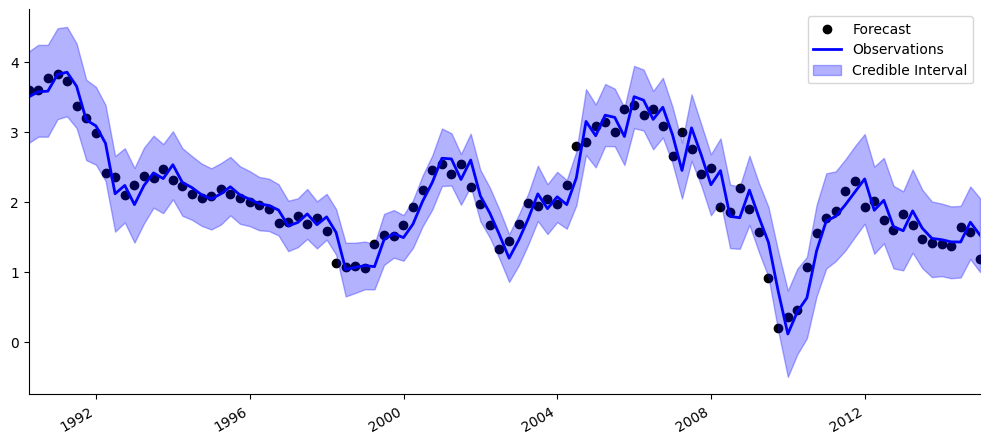

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
plot_data_forecast(fig, ax,
                   Y[forecast_start:forecast_end+1],
                   forecast, samples,
                   dates[forecast_start:forecast_end+1],
                   linewidth = 2)

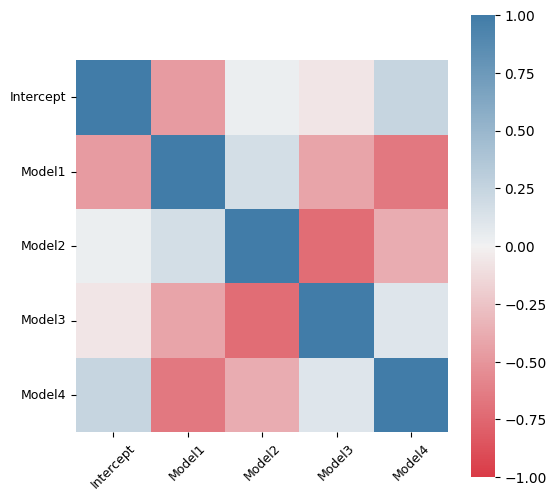

In [21]:
D = np.sqrt(mod.R.diagonal()).reshape(-1,1)
corr = mod.R/D/D.T

fig, ax = plt.subplots(figsize=(6,6))
plot_corr(fig, ax, corr=corr, labels = ['Intercept', 'Model1', 'Model2', 'Model3', 'Model4']);

In [22]:
import matplotlib.pyplot as plt

from pybats.plot import plot_data_forecast
from pybats.latent_factor import Y_lf, seas_weekly_lf, hol_lf, multi_latent_factor
from pybats.shared import load_dcmm_latent_factor_example
from pybats.analysis import analysis
from pandas.tseries.holiday import USFederalHolidayCalendar
from pybats.point_forecast import median

data = load_dcmm_latent_factor_example()
totaldata, data = data.values()
totaldata['Y'] = np.log(totaldata['Y'] + 1)

totaldata.head()

,Y,X
2014-06-01,5.613128,-0.133124
2014-06-02,5.602119,-0.070102
2014-06-03,5.831882,1.020901
2014-06-04,5.393628,2.219605
2014-06-05,5.267858,-0.970556


In [23]:
k = 14 # Number of days ahead that we will forecast
prior_length = 21
holidays=USFederalHolidayCalendar.rules

# Define forecast range for final year of data
T = len(totaldata)
forecast_end_date = totaldata.index[-k]
forecast_start_date = forecast_end_date - pd.DateOffset(days=365)

# Get multiscale signal (a latent factor) from higher level log-normal model
latent_factors = analysis(totaldata['Y'].values, totaldata['X'].values, k,
                         forecast_start_date, forecast_end_date,
                         family="normal", dates=totaldata.index,
                         seasPeriods=[7], seasHarmComponents=[[1,2,3]],
                         holidays=holidays,
                         ret=['new_latent_factors'],
                         new_latent_factors= [Y_lf, seas_weekly_lf, hol_lf],
                         prior_length=prior_length)

beginning forecasting


In [24]:
my_latent_factors = [lf.p for lf in latent_factors]
my_latent_factors


[1, 7, 11]

In [25]:
latent_factor_names = ['Total Sales', 'Weekly Seasonal', 'Holiday']
for lf, name in zip(latent_factors, latent_factor_names):
    print(name + ' mean:', lf.get_lf(forecast_start_date)[0].round(2))

Total Sales mean: 5.56
Weekly Seasonal mean: [ 0.    0.    0.    0.   -0.06  0.    0.  ]
Holiday mean: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
print(latent_factor_names[0] + ' forecast mean: ', np.array(latent_factors[0].get_lf_forecast(forecast_start_date)[0]).round(2))

Total Sales forecast mean:  [5.42 5.65 5.76 5.56 5.39 5.36 5.35 5.43 5.63 5.8  5.13 5.38 5.36 5.35]


In [27]:
print(latent_factor_names[1] + ' forecast mean: ')
print(np.array(latent_factors[1].get_lf_forecast(forecast_start_date)[0]).round(2))

Weekly Seasonal forecast mean: 
[[ 0.    0.    0.    0.   -0.06  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.29]
 [ 0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.12  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.13  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.15  0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.06  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.29]
 [ 0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.12  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.13  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.15  0.    0.    0.  ]]


In [28]:
multi_lf = multi_latent_factor(latent_factors[:3])
print('Total dimension :', multi_lf.p)

Total dimension : 19


In [29]:
nsamps = 1000

mod, forecast_samples = analysis(data['Y'].values, data['X'].values, k,
                                 forecast_start_date, forecast_end_date,
                                 nsamps=nsamps,
                                 latent_factor = multi_lf,
                                 dates=data.index,
                                 prior_length = prior_length,
                                 s0=5, dellf=1)

forecast = median(forecast_samples)

beginning forecasting


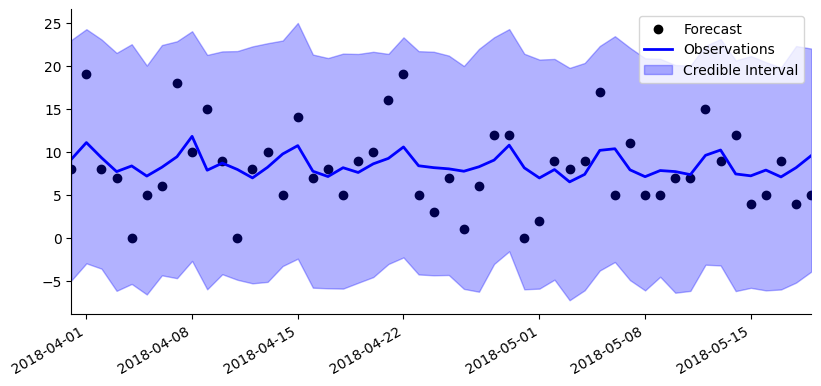

In [30]:
horizon = 1 
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax,
                        data.loc[start_date:end_date].Y,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)

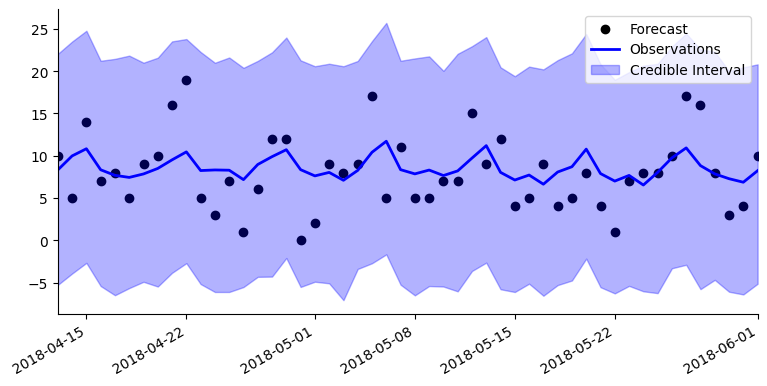

In [31]:
horizon = 14 
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax,
                        data.loc[start_date:end_date].Y,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)

In [32]:
# from pybats.latent_factor import multi_latent_factor

In [33]:
# k = 1 #Forecast horizon: 1-quarter ahead
# forecast_start = 50
# forecast_end = 149
# agents=[1,2,3,4]
# nagents = len(agents)
# Y = data['Inflation']

# lf = multi_latent_factor(
#     forecast_dates=dates,
#     p = nagents,
#     k = k)